# Web Scraping Indeed.com for Data Science Job Listings & Predicting Salaries

This project entailed using a web scraper to collect data on job postings for data scientist positions and building a binary classifier to determine whether a given job listing will be above or below the median salary.

Information scraped from the webpage that was used for prediction includes: job location and job title. 
While only a small subset of the job listings included salary data, the information gained from them was used to approximate the median salary for the data science job market.

Over 10,500 data science job listings were scraped over the period of three days. Out of the 10,500, only 493 listings provided annual salary information. Using the location and job title, I built several models to predict whether the salary of a given position would fall below or above the median.

### Scraping job listings from Indeed.com using BeautifulSoup

In [1]:
import requests
import bs4
from bs4 import BeautifulSoup
import urllib 
from urllib2 import urlopen
from itertools import compress
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_predict
from sklearn import metrics


%matplotlib inline

URL = 'http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10'
html = urllib.urlopen(URL).read()
soup = BeautifulSoup(html, 'html.parser', from_encoding="utf-8")



/Users/valeriarozenbaum/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Writing 4 functions to extract each item: location, company, job, and salary.

In [148]:
def extract_location(result):
    location= []
    for i in result.find_all(name = 'span', attrs={'class': 'location'}):        
        location.append(i.text)
    non_sponsored_links = []
    for i in result.find_all('td',{'class':'snip'}):
        try:
            if i.find('div',{'class':'result-link-bar-container'}).renderContents:
                non_sponsored_links.append(True) 
        except:
            non_sponsored_links.append(False)
    location = list(compress(location, non_sponsored_links))
    location = [item.encode('UTF8') for item in location]
    return location

In [149]:
extract_location(soup)

['New York, NY',
 'New York, NY',
 'New York, NY',
 'New York, NY',
 'New Hyde Park, NY 11040',
 'New York, NY',
 'New York, NY',
 'New York, NY',
 'New York, NY',
 'New York, NY']

In [150]:
#The company is set in a span with class='company'.
def extract_company(result):
    company= []
    for i in result.find_all(name = 'span', attrs={'class': 'company'}):
        try: 
            company.append(result.find_all(name = 'span', attrs = {'a data-tn-elemen': 'companyName'}).text)
        except:
            company.append(i.text)
    non_sponsored_links = []
    for i in result.find_all('td',{'class':'snip'}):
        try:
            if i.find('div',{'class':'result-link-bar-container'}).renderContents:
                non_sponsored_links.append(True) 
        except:
            non_sponsored_links.append(False)
    company = list(compress(company, non_sponsored_links))
    company = [item.encode('UTF8') for item in company]
    company = [item.replace("\n","") for item in company]
    company = [item.replace(" ","") for item in company]
    return company

extract_company(soup)

['HarperCollinsPublishersInc.',
 'Dailymotion',
 'AdTheorent',
 'FlatironHealth',
 'NorthwellHealth',
 'AdTheorent',
 'ResearchFoundationofTheCityUniversityofNew...',
 'HudsonData',
 'AIG',
 'AdTheorent']

In [151]:
#The title of a job is in a link with class set to jobtitle and a data-tn-element="jobTitle.
def extract_title(result):
    titles = []
    for i in result.find_all('h2',{"class":"jobtitle"}): 
        try:
            titles.append(i.find('a',{"class":"turnstileLink"})['title']) #sponsored
        except:
            titles.append("Empty")
    non_sponsored_links = []
    for i in result.find_all('td',{'class':'snip'}):
        try:
            if i.find('div',{'class':'result-link-bar-container'}).renderContents:
                non_sponsored_links.append(True) 
        except:
            non_sponsored_links.append(False)
    titles = list(compress(titles, non_sponsored_links))
    titles = [item.encode('UTF8') for item in titles]
    return titles
    
extract_title(soup)

['Quantitative Scientist',
 'Data Research Analyst - Office of Chief Nurse Executive',
 'Director Data Science',
 'Research Project Coordinator',
 'Sr. Data Scientist',
 'Scientist - Business Process Modeling and Simulation',
 'Senior Data Scientist']

In [152]:
def extract_salary(result):
    salary = []
    for i in result.find_all('td',{'class':'snip'}):
        try: 
            raw_salary = i.find('nobr').text
            salary.append(raw_salary)
        except:
            salary.append('EMPTY')
    non_sponsored_links = []
    for i in result.find_all('td',{'class':'snip'}):
        try:
            if i.find('div',{'class':'result-link-bar-container'}).renderContents:
                non_sponsored_links.append(True) 
        except:
            non_sponsored_links.append(False)
    salary = list(compress(salary, non_sponsored_links))
    salary = [item.encode('UTF8') for item in salary]
    return salary

extract_salary(soup)

['EMPTY',
 'EMPTY',
 'EMPTY',
 'EMPTY',
 'EMPTY',
 'EMPTY',
 'EMPTY',
 'EMPTY',
 'EMPTY',
 'EMPTY']

### Scaling up the  scraping

In [153]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"

max_results_per_city = 500 #This will return 500 results for each city

results = []

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Houston', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Miami', 'Ann+Arbor', 'Washington+DC']):
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        # Append to the full set of results     
        url = url_template.format(city, start)
        html = urllib.urlopen(url).read()
        soup = BeautifulSoup(html, 'html.parser', from_encoding="utf-8")
        location = extract_location(soup)
        company = extract_company(soup)
        title = extract_title(soup)
        salary = extract_salary(soup)
        for k in range(10):
            result = []
            if k < len(location):
                result.append(location[k])
            if k < len(company):
                result.append(company[k])
            if k < len(title):
                result.append(title[k])
            if k < len(salary):
                result.append(salary[k])
            if result:
                results.append(result)

results

[['Houston, TX',
  'PlatinumSolutions',
  'Senior Data Scientist',
  '$80,000 - $120,000 a year'],
 ['Houston, TX', 'HP', 'Ultimate Hoops Statistician', 'EMPTY'],
 ['Houston, TX',
  'DavidWeekleyHomes',
  'Associate Statistical Analyst, HSR',
  'EMPTY'],
 ['Houston, TX', 'Honeywell', 'Market Research Analyst', 'EMPTY'],
 ['Sugar Land, TX 77478', 'LifeTimeFitness', 'Research Scientist', 'EMPTY'],
 ['Houston, TX',
  'MDAndersonCancerCenter',
  'Research Scientist - Cardiology Research',
  'EMPTY'],
 ['Houston, TX 77056 (Galleria-Uptown area)',
  'Weatherford',
  'Structuring Quantitative Analyst',
  'EMPTY'],
 ['Houston, TX 77030 (Medical area)', 'HoustonMethodist', 'EMPTY'],
 ['Houston, TX', 'MDAndersonCancerCenter', 'EMPTY'],
 ['Houston, TX 77056 (Galleria-Uptown area)', 'JustEnergy', 'EMPTY'],
 ['Houston, TX',
  'MDAndersonCancerCenter',
  'Lead Retail Pricing Scientist',
  'EMPTY'],
 ['Houston, TX',
  'MDAndersonCancerCenter',
  'Research Scientist - LCMS',
  'EMPTY'],
 ['Houston, TX

### Using the previously created functions to parse out 4 fields - location, title, company and salary. Creating a dataframe from the results with the fields as the columns.

In [154]:
df = pd.DataFrame(data=results)
df.rename(columns = {0:'Location'}, inplace = True)
df.rename(columns = {1:'Company'}, inplace = True)
df.rename(columns = {2:'Title'}, inplace = True)
df.rename(columns = {3:'Salary'}, inplace = True)

df.head()


Location            Company  \
0           Houston, TX  PlatinumSolutions   
1           Houston, TX                 HP   
2           Houston, TX  DavidWeekleyHomes   
3           Houston, TX          Honeywell   
4  Sugar Land, TX 77478    LifeTimeFitness   

                                Title                     Salary  
0               Senior Data Scientist  $80,000 - $120,000 a year  
1         Ultimate Hoops Statistician                      EMPTY  
2  Associate Statistical Analyst, HSR                      EMPTY  
3             Market Research Analyst                      EMPTY  
4                  Research Scientist                      EMPTY

In [2]:
def eda(dataframe): 
    print "missing values \n", dataframe.isnull().sum() 
    print "dataframe types \n", dataframe.dtypes
    print "dataframe shape \n", dataframe.shape     
    print "dataframe describe \n", dataframe.describe()
    print "dataframe length =", len(dataframe) 
    print "dataframe Salary unique =", dataframe.Salary.unique()
    for item in dataframe:
        print item
        print dataframe[item].nunique()

In [156]:
eda(df)

missing values 
Location      0
Company       0
Title         0
Salary      155
dtype: int64
dataframe types 
Location    object
Company     object
Title       object
Salary      object
dtype: object
dataframe shape 
(5168, 4)
dataframe describe 
           Location        Company           Title Salary
count          5168           5168            5168   5013
unique          655           1942            3323    206
top     Chicago, IL  BallAerospace  Data Scientist  EMPTY
freq            287            112             195   4652
dataframe length = 5168
dataframe Salary unique = ['$80,000 - $120,000 a year' 'EMPTY' None '$120 an hour' '$43,794 a year'
 '$105,000 a year' '$46,831 a year' '$40,800 - $79,100 a year'
 '$66,400 - $99,600 a year' '$65,000 a year' '$60,000 a year'
 '$110,000 - $140,000 a year' '$100,000 - $150,000 a year'
 '$65,000 - $80,000 a year' '$40 an hour' '$50,000 a year'
 '$70,000 - $100,000 a year' '$140,000 a year' '$180,000 - $200,000 a year'
 '$66,829 - $110,664

### The salary information needs some serious cleanup. 

1. Only a small number of the scraped results have salary information.
1. Some of the salaries are not yearly but hourly, weekly or monthly, these can't be used without making some large assumptions
1. Some of the entries may be duplicates
1. The salaries are given as text and usually with ranges.

In [157]:
df['Salary'].replace(regex=True,inplace=True,to_replace='\$',value='') #Removing '$' character
df['Salary'].replace(regex=True,inplace=True,to_replace=',',value=r'') # Removing ','
df['Salary'].replace(regex=True,inplace=True,to_replace='a year',value='year') #changing 'a year' to just 'year'
df['Salary'].replace(regex=True,inplace=True,to_replace='a month',value='month')#changing 'a month' to 'month'
df['Salary'].replace(regex=True,inplace=True,to_replace='an hour',value='hour')#changing 'an hour' to 'hour'

In [158]:
df['Salary'].replace('EMPTY', np.NaN, inplace = True) #Changing 'EMPTY' salary values to NaN
df['Salary'].replace('None', np.NaN, inplace= True) #Changing 'None' salary values to NaN
df = df.dropna() #Dropping NaN
df.shape

(361, 4)

In [159]:
#We wouldn't be able to use the month and hour salary data without making some major assumptions about the results.
#I would prefer to avoid that so I am going to create a new dataframe that only contains the yearly salary data
to_drop = ['month', 'hour'] 
year_df3 = df[~df['Salary'].str.contains('|'.join(to_drop))]

eda(year_df3)

missing values 
Location    0
Company     0
Title       0
Salary      0
dtype: int64
dataframe types 
Location    object
Company     object
Title       object
Salary      object
dtype: object
dataframe shape 
(254, 4)
dataframe describe 
           Location               Company                  Title       Salary
count           254                   254                    254          254
unique           73                   124                    188          138
top     Chicago, IL  WorkbridgeAssociates  Senior Data Scientist  160000 year
freq             34                    16                      7           12
dataframe length = 254
dataframe Salary unique = ['80000 - 120000 year' '43794 year' '105000 year' '46831 year'
 '40800 - 79100 year' '66400 - 99600 year' '65000 year' '60000 year'
 '110000 - 140000 year' '100000 - 150000 year' '65000 - 80000 year'
 '50000 year' '70000 - 100000 year' '140000 year' '180000 - 200000 year'
 '66829 - 110664 year' '250000 year' '40000 - 4500

In [160]:
#Now that we're sure that we only have yearly data I want to remove the string year from the field
year_df3['Salary'].replace(regex=True,inplace=True,to_replace='year',value='')
year_df3.shape

/Users/valeriarozenbaum/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(254, 4)

In [161]:
#Writing a function that takes a salary string and converts it to a number, averaging a salary range if necessary

def extract_salary(salary_data):
    k = []
    for item in salary_data.split():
        try:
            k.append(float(item))
        except ValueError:
            pass
    if len(k)>1: #If k is longer than 1
        k = (k[0]+k[1])/2 # k equals - k in first position + k in second position, divided by 2
    else:
        k = k[0] #else - single k's are just equal to k's in the first position
    return k


In [162]:
year_df3['Avg_Salary'] = year_df3['Salary'].apply(extract_salary)

/Users/valeriarozenbaum/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Saving the results as CSVs

In [136]:
year_df2.to_csv('/Users/valeriarozenbaum/Documents/indeed_full_clean2.csv', index=False) #Saving second dataframe

NameError: name 'year_df2' is not defined

In [167]:
year_df3.to_csv('/Users/valeriarozenbaum/Documents/indeed_full_clean3.csv', index=False) #Saving third dataframe

In [172]:
year_df.to_csv('/Users/valeriarozenbaum/Documents/indeed_full_clean.csv', index=False) #Saving first dataframe

### Reading in the data

In [ ]:
year_df = pd.read_csv('/Users/valeriarozenbaum/Documents/indeed_full_clean.csv')#Reading in first dataframe

In [46]:
year_df2 = pd.read_csv('/Users/valeriarozenbaum/Documents/indeed_full_clean2.csv')#Reading in second dataframe

(255, 5)

In [ ]:
year_df3 = pd.read_csv('/Users/valeriarozenbaum/Documents/indeed_full_clean3.csv') #Reading in third dataframe

### Concatinating

In [173]:
indeed = pd.concat([year_df,year_df2,year_df3]) #concatinating the three dataframes into the final 

In [179]:
indeed.drop_duplicates(keep='first', inplace=True) #dropping duplicate entries 

In [201]:
indeed.shape #Checking the shape of the dataframe. It looks like after dropping the duplicates we are left with
             #493 yearly salary results we can use. 

(493, 7)

In [183]:
#Creating empty lists for city and state data  
city = []
state = []

for row in indeed['Location']:
    try:
        # Split the row by comma and append
        # everything before the comma to city list
        city.append(row.split(',')[0])
        # Split the row by comma and append
        # everything after the comma to state list
        state.append(row.split(',')[1])
    # There shouldn't be an issue with the structure but if there is 
    except:
        # append a missing value to city
        city.append(np.NaN)
        # append a missing value to state
        state.append(np.NaN)

# Create two new columns from city and state
indeed['City'] = city
indeed['State'] = state

In [184]:
# strip away all characters after the last character in the state abbreviation
indeed['State'] = indeed['State'].map(lambda x: str(x)[:3]) 

In [3]:
indeed.to_csv('/Users/valeriarozenbaum/Documents/last_complete_indeed_final.csv', index=False) #Saving final dataframe

NameError: name 'indeed' is not defined

## Predicting salaries using Random Forests + Logistic Regression

### Loading in the the data of scraped salaries

In [3]:
indeed = pd.read_csv('/Users/valeriarozenbaum/Documents/last_complete_indeed_final.csv') #reading in the file

In [5]:
eda(indeed)

missing values 
Avg_Salary    0
Company       0
Location      0
Salary        0
Title         0
City          0
State         0
dtype: int64
dataframe types 
Avg_Salary    float64
Company        object
Location       object
Salary         object
Title          object
City           object
State          object
dtype: object
dataframe shape 
(493, 7)
dataframe describe 
          Avg_Salary
count     493.000000
mean   105093.612576
std     46471.402353
min        85.000000
25%     67500.000000
50%    100000.000000
75%    135000.000000
max    250000.000000
dataframe length = 493
dataframe Salary unique = ['80000 - 120000 year' '43794 year' '105000 year' '46831 year'
 '40800 - 79100 year' '66400 - 99600 year' '65000 year' '60000 year'
 '100000 - 150000 year' '50000 year' '140000 year' '66829 - 110664 year'
 '180000 - 200000 year' '53088 - 92814 year' '250000 year'
 '40000 - 45000 year' '196000 year' '160000 year' '70000 - 80000 year'
 '75000 - 105000 year' '110000 - 160000 year' '150000 y

### Since this is a binary classification problem, I want to compute the median salary to create a new variable that is True (1) when the salary is above the median and is False (0) when the salary is below the median.

In [49]:
#Looks like our median salary is 100K
median_salary = indeed['Avg_Salary'].median()
median_salary

100000.0

In [50]:
#Defining a function that will return a 1 if a salary is above 100K and will return a 0 if the salary is below
def above_median(amount):
    if amount > indeed['Avg_Salary'].median():
        return 1
    else:
        return 0

In [51]:
#Creating a 'Salary_Above_Median' column that will house our 1's and 0's and define which salaries are above and below
#the median
indeed['Salary_Above_Median'] = indeed['Avg_Salary'].apply(lambda x: above_median(x))
indeed['Salary_Above_Median'].value_counts()

#It looks like our results are relatively close with but majority of job listings have a salary below the median.

0    257
1    236
Name: Salary_Above_Median, dtype: int64

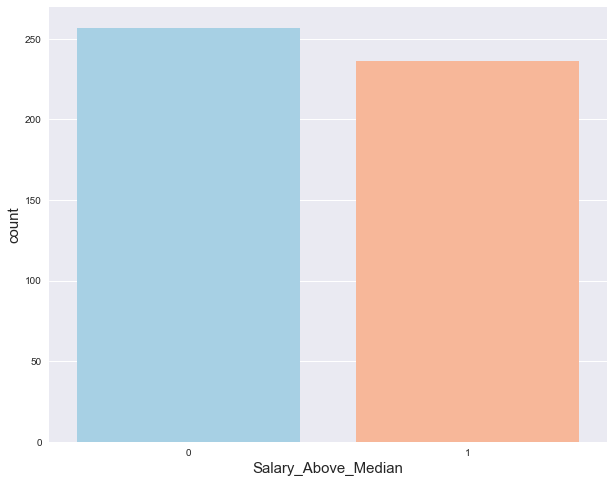

In [52]:
from matplotlib import pyplot

fig, ax = pyplot.subplots()
fig.set_size_inches(10, 8)
sns.set_context(rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})

sns.countplot(ax=ax, data = indeed, x = 'Salary_Above_Median', palette='RdBu_r', saturation=1.0)

sns.plt.show()
fig.savefig('Sat_Jobs_Below_and_Above_Median_Salary.png')

### Computing the baseline accuracy for the model

In [54]:
#The baseline accuracy for this would be close to 50/50 at .48
all_salary = float(indeed['Salary_Above_Median'].count())
all_above_median = float(indeed['Salary_Above_Median'][indeed['Salary_Above_Median'] == 1].count())
base = all_above_median/all_salary

print base

0.478701825558


### Creating a Random Forest model to predict High/Low salary using the location data as the features. 

In [55]:
#Since our dataframe has location split by City and State, I would like to take a look at whether one is a better 
#predictor of salary than the other.
#Below, I am getting dummies and setting the X variable as 'City' and the y as the 'Salary_Above_Median' column. 
#Then, I am doing a train, test, split on the data with a training size of .77 and testing size of .33.
#I am then calling the Random Forest Classifier and fitting the model on my X_train and y_train data.

X = pd.get_dummies(indeed['City'])
y = indeed['Salary_Above_Median']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33)

rf_city = RandomForestClassifier(class_weight='balanced')

rf_city.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [56]:
y_pred = rf_city.predict(X_test)
print confusion_matrix(y_test,y_pred)  #Printing the confusion matrix for city

[[48 27]
 [16 72]]


In [57]:
print accuracy_score(y_pred, y_test) #Getting the accuracy score for our city model. Pretty good predictor.

0.736196319018


In [58]:
print classification_report(y_test,y_pred) #Getting the model classification report for city.

             precision    recall  f1-score   support

          0       0.75      0.64      0.69        75
          1       0.73      0.82      0.77        88

avg / total       0.74      0.74      0.73       163



In [59]:
#Here I am  doing the same thing as above except on the 'State' column
X = pd.get_dummies(indeed['State'])
y = indeed['Salary_Above_Median']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

rf_state = RandomForestClassifier(class_weight='balanced')

rf_state.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [60]:
y_pred = rf_state.predict(X_test)  #Printing the confusion matrix for state
print confusion_matrix(y_test,y_pred)

[[37 46]
 [15 65]]


In [61]:
accuracy_score(y_pred, y_test) #It doesn't look like state is a good predictor

0.62576687116564422

In [62]:
print classification_report(y_test,y_pred) #Printing the classification report for state

             precision    recall  f1-score   support

          0       0.71      0.45      0.55        83
          1       0.59      0.81      0.68        80

avg / total       0.65      0.63      0.61       163



In [63]:
#Now to combine the two locations to see whether they are good predictors of salary
X = pd.get_dummies(indeed[['City','State']])
y = indeed['Salary_Above_Median']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

rf_city_state = RandomForestClassifier(class_weight='balanced')

rf_city_state.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [64]:
y_pred = rf_city_state.predict(X_test) #printing the confusion matrix for our city_state model
print confusion_matrix(y_test,y_pred)

[[42 41]
 [12 68]]


In [65]:
accuracy_score(y_pred, y_test) #Combing our city and state variables made the model a bit better but still not as 
                               #good as just the city model

0.67484662576687116

In [66]:
print classification_report(y_test,y_pred) #Printing the classification report

             precision    recall  f1-score   support

          0       0.78      0.51      0.61        83
          1       0.62      0.85      0.72        80

avg / total       0.70      0.67      0.67       163



### Creating a few new variables in the dataframe by extracting keywords from the job titles for later modeling

In [68]:
#I'm going to grab some keywords from the title column which I think may be good predictors of salary.
#The key words below are going to get their own columns in the dataframe and be represented by a 1 when they
#appear in an individual job title. When they are not found in a job title they will be represented with a 0.
indeed['visualization'] = map(int, indeed['Title'].str.lower().str.contains('vis'))
indeed['scientist'] = map(int, indeed['Title'].str.lower().str.contains('scientist'))
indeed['engineer'] = map(int, indeed['Title'].str.lower().str.contains('engineer'))
indeed['specialist'] = map(int, indeed['Title'].str.lower().str.contains('specialist'))
indeed['analyst'] = map(int, indeed['Title'].str.lower().str.contains('analyst'))
indeed['manager'] = map(int, indeed['Title'].str.lower().str.contains('manager')|
                             indeed['Title'].str.lower().str.contains('mngr')|
                             indeed['Title'].str.lower().str.contains('mgr'))
indeed['senior'] = map(int, (indeed['Title'].str.lower().str.contains('senior') |
                         indeed['Title'].str.lower().str.contains('snr') |
                         indeed['Title'].str.lower().str.contains('sr')))

title_descriptions = ['visualization','scientist','engineer','specialist','analyst','manager', 'senior']
for description in title_descriptions:
    print(description, indeed[description].sum())

('visualization', 8)
('scientist', 180)
('engineer', 40)
('specialist', 9)
('analyst', 117)
('manager', 22)
('senior', 95)


### Tfidf Vectorizer and  Logistic Regression on the job titles

In [70]:
#Creating a tfid vectorizer and and transforming the entire title column into a matrix and naming it df
tvec = TfidfVectorizer()
tvec.fit(indeed.Title)

df  = pd.DataFrame(tvec.transform(indeed.Title).todense(),
                   columns=tvec.get_feature_names())

In [71]:
#Fitting all of df (transformed indeed title) as the X and setting the Salary_Above_Median as the y
#Running a train test split with a train size of .77 and test size of .33
X = df
y = indeed.Salary_Above_Median
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33)

In [72]:
#Fitting a logistic regression model
lg_title = LogisticRegression()
lg_title.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [73]:
y_pred = lg_title.predict(X_test) # getting the model score. Looks like the title is a pretty good predictor of salary
accuracy_score(y_pred, y_test)

0.7975460122699386

In [74]:
confusion_matrix(y_test,y_pred)  #printing the confusion matrix

array([[65, 18],
       [15, 65]])

In [75]:
print classification_report(y_test,y_pred) #printing the classification report

             precision    recall  f1-score   support

          0       0.81      0.78      0.80        83
          1       0.78      0.81      0.80        80

avg / total       0.80      0.80      0.80       163



In [76]:
#Doing a gradient boost
X = df
y = indeed.Salary_Above_Median

cv = StratifiedKFold(y, n_folds=3, shuffle=True, random_state=41)

gbc = GradientBoostingClassifier()
s = cross_val_score(gbc, X, y, cv=cv, n_jobs=-1)
print "{} Score:\t{:0.3} ± {:0.3}".format("Gradient Boosting", s.mean().round(3), s.std().round(3))

Gradient Boosting Score:	0.856 ± 0.033


In [88]:
#Running a train, test, split and fitting the title dataframe to a random forest model
X = df
y = indeed['Salary_Above_Median']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

rf_title = RandomForestClassifier(class_weight='balanced')

rf_title.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [90]:
y_pred = rf_title.predict(X_test) #printing the confusion matrix for our title model
print confusion_matrix(y_test,y_pred)

[[82  4]
 [16 61]]


In [91]:
accuracy_score(y_pred, y_test) #According to our rfmodel,the job title is a pretty damn good predictor of salary

0.87730061349693256

In [92]:
print classification_report(y_test,y_pred)

             precision    recall  f1-score   support

          0       0.84      0.95      0.89        86
          1       0.94      0.79      0.86        77

avg / total       0.88      0.88      0.88       163



In [93]:
#Extracting the feature importance from the random forest title model.
#It looks like a couple of the keywords that I extracted from the dataframe earlier are popping up. However,
#the majority of these are not ones that I thought of being good predictors.

rf_features = pd.DataFrame(rf_title.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
rf_features.head(10)

importance
data             0.156494
analyst          0.063656
research         0.047665
scientist        0.040732
machine          0.031026
senior           0.023991
engineer         0.023856
lead             0.023007
learning         0.019139
environmental    0.018679

### Running a Logistic Regression on just the job title keywords that were extracted earlier

In [32]:
#Taking just the key words that were created earlier and setting a train test split.
X = indeed[['visualization','scientist','engineer','specialist','analyst','manager', 'senior']]
y = indeed['Salary_Above_Median']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(330, 7) (330,)
(163, 7) (163,)


In [33]:
#Fitting a logistic regression model on the keyword columns and getting the accuracy score.
#Hmm, it doesn't look like the keywords I chose are the best predictors of salary
lg_keywords= LogisticRegression()
lg_keywords.fit(X_train,y_train)

y_pred = lg_keywords.predict(X_test)
accuracy_score(y_pred, y_test)

0.71779141104294475

In [34]:
confusion_matrix(y_test,y_pred)

array([[64, 22],
       [24, 53]])

In [35]:
print classification_report(y_test,y_pred)

             precision    recall  f1-score   support

          0       0.73      0.74      0.74        86
          1       0.71      0.69      0.70        77

avg / total       0.72      0.72      0.72       163



### Using cross-validation to evaluate the job title model


In [78]:
#I am doing a 6 fold cross validation on my title model (df)
scores = cross_val_score(lg_title, X, y, cv = 6)

In [79]:
print scores #Below are my 6 model scores

[ 0.86746988  0.89156627  0.91463415  0.84146341  0.87804878  0.67901235]


In [80]:
predictions = cross_val_predict(lg_keywords, X , y, cv=6)

In [81]:
accuracy = accuracy_score(y, predictions)    #This is a decent model score that falls between the high score of 0.877
print "Cross-Predicted Accuracy:", accuracy  #that I got from the random forest and the low of 0.797 that I got from 
                                             # the logistic regression model

Cross-Predicted Accuracy: 0.84584178499
